In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
import os


##**1. Preparación de los datos**

In [3]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets


In [4]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [5]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [6]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [7]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [8]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [9]:
#Sólo la columna C6H6
df = df[['C6H6']]
print(df)

                     C6H6
Datetime                 
2004-03-10 18:00:00  11.9
2004-03-10 19:00:00   9.4
2004-03-10 20:00:00   9.0
2004-03-10 21:00:00   9.2
2004-03-10 22:00:00   6.5
...                   ...
2005-04-04 10:00:00  13.5
2005-04-04 11:00:00  11.4
2005-04-04 12:00:00  12.4
2005-04-04 13:00:00   9.5
2005-04-04 14:00:00  11.9

[9357 rows x 1 columns]


##**2. Creacion de lags y feature para SVR**


Se va a usar el algoritmo SVR (Support Vector Regression) que es una extensión del SVM (Support Vector Machine) para series temporales. La funcionalidad de este algoritmo es un problema de regresión: busca el hiperplano por la que pasen la mayor cantidad de puntos teniendo en cuenta un margen.

https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/


In [10]:
# Definir número de lags y periodo estacional
lags = 24  # Lags para capturar información pasada
seasonal_period = 24  # Estacionalidad diaria

In [11]:
# Fucnion para crear las columnas de lags y características estacionales

def create_lagged_features(data, lags, seasonal_period):
    df = pd.DataFrame(data)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['C6H6'].shift(lag)
    for period in range(1, seasonal_period + 1):
        df[f'seasonal_lag_{period}'] = df['C6H6'].shift(period)
    df['target'] = df['C6H6']
    df.dropna(inplace=True)
    return df

In [12]:
#Crea el data frame con lagged y caracteristicas estacionales
df_lagged = create_lagged_features(df, lags, seasonal_period)
df_lagged.head()

,C6H6,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,seasonal_lag_16,seasonal_lag_17,seasonal_lag_18,seasonal_lag_19,seasonal_lag_20,seasonal_lag_21,seasonal_lag_22,seasonal_lag_23,seasonal_lag_24,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,20.8,11.2,8.3,8.8,11.5,7.3,5.2,5.0,6.3,9.5,...,2.3,3.3,3.6,4.7,6.5,9.2,9.0,9.4,11.9,20.8
2004-03-11 19:00:00,27.4,20.8,11.2,8.3,8.8,11.5,7.3,5.2,5.0,6.3,...,1.7,2.3,3.3,3.6,4.7,6.5,9.2,9.0,9.4,27.4
2004-03-11 20:00:00,24.0,27.4,20.8,11.2,8.3,8.8,11.5,7.3,5.2,5.0,...,1.3,1.7,2.3,3.3,3.6,4.7,6.5,9.2,9.0,24.0
2004-03-11 21:00:00,12.8,24.0,27.4,20.8,11.2,8.3,8.8,11.5,7.3,5.2,...,1.1,1.3,1.7,2.3,3.3,3.6,4.7,6.5,9.2,12.8
2004-03-11 22:00:00,4.7,12.8,24.0,27.4,20.8,11.2,8.3,8.8,11.5,7.3,...,1.6,1.1,1.3,1.7,2.3,3.3,3.6,4.7,6.5,4.7


In [13]:
#Separa los valores en X e Y
X = df_lagged.drop(columns=['target']).values
y = df_lagged['target'].values


In [14]:
#Separación train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [15]:
#Se escalan los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##**3. Entrenamiento del modelo SVR**

**Parametros SVR**

kernel: especifica el tipo de función kernel a utilizar en el algoritmo SVM.
Opciones comunes:
* 'linear': funcion Kernel lineal
* 'poly': función kernel polinómica.
* 'rbf': función kernel de base radial (Radial Basis Function).
* 'sigmoid': función kernel sigmoide.

Parametro C: de regularización. Controla el trade-off entre lograr un margen grande y clasificar correctamente los puntos de entrenamiento. Distancia del hiperplano.

gamma: es un parámetro específico del kernel RBF, polinómico y sigmoide. Define cómo influye un solo ejemplo de entrenamiento.
Un valor pequeño de gamma (por ejemplo, 0.1) significa que la influencia de un solo punto de entrenamiento es grande, y por lo tanto, el modelo es más suave.
Un valor grande de gamma significa que la influencia de un solo punto de entrenamiento es pequeña, lo que resulta en un modelo más complejo y menos suave.

El tipo de kernel se selecciona de acuerdo al conjunto de datos, en nuestro caso como los datos no son lineales usaremos el kernel radia, también porque es el más habitual.



**Modelo con kernel radial**

In [ ]:
# Definición del modelo y entrenamiento
model1 = SVR(kernel='rbf', C=1000, gamma=0.1)
model1.fit(X_train_scaled, y_train)

SVR(C=1000, gamma=0.1)

In [ ]:
# Predicción
y_pred = model1.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)


MSE: 3.2711140591623997
MAE: 0.9620375433630549


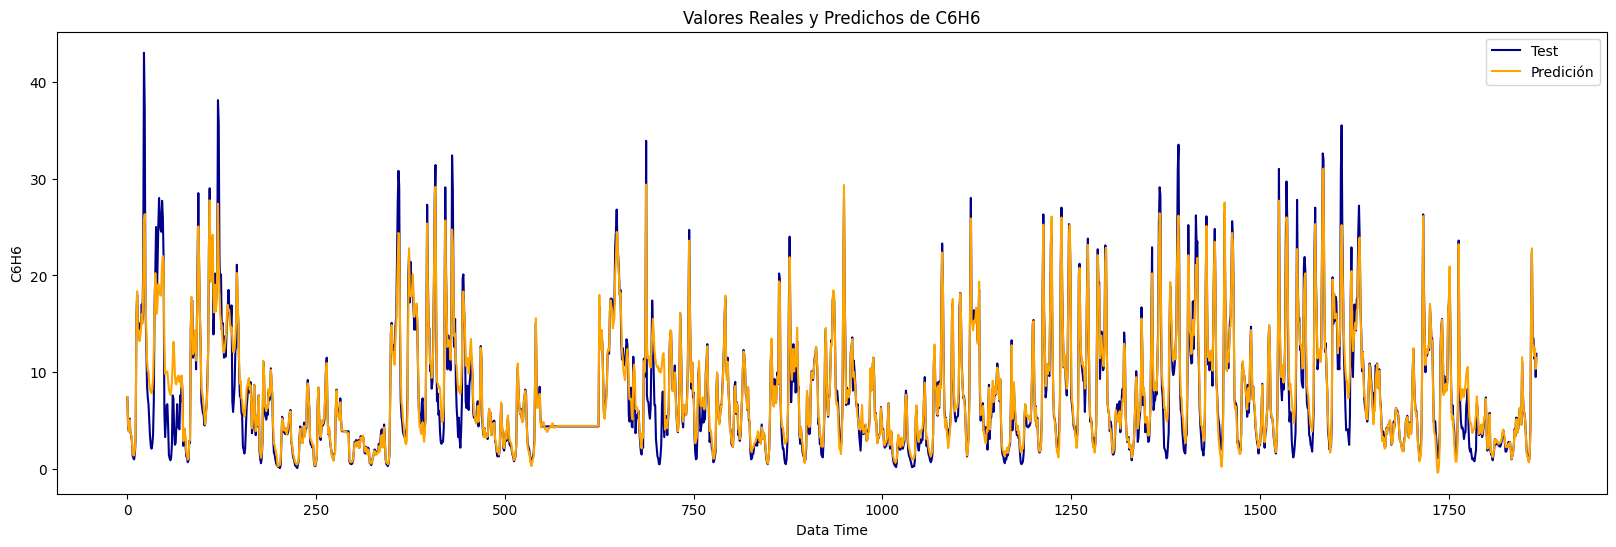

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Data Time')
plt.ylabel('C6H6')
plt.title('Valores Reales y Predichos de C6H6')
plt.legend()
plt.show()


In [ ]:
# Modelo 2 con otra C

model2 = SVR(kernel='rbf', C=100, gamma=0.1)
model2.fit(X_train_scaled, y_train)


SVR(C=100, gamma=0.1)

In [ ]:
y_pred = model2.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)



MSE: 3.2714540167071995
MAE: 0.9622394812179226


In [ ]:
# Modelo 3 con otra C

model3 = SVR(kernel='rbf', C=10, gamma=0.1)
model3.fit(X_train_scaled, y_train)


SVR(C=10, gamma=0.1)

In [ ]:
y_pred = model3.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)


MSE: 3.2377026595357243
MAE: 0.9548799663504712


In [ ]:
# Modelo 4 con otra C

model4 = SVR(kernel='rbf', C=1, gamma=0.1)
model4.fit(X_train_scaled, y_train)


SVR(C=1, gamma=0.1)

In [ ]:
y_pred = model4.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)


MSE: 6.846287233188814
MAE: 1.4995228930258293


In [16]:
# Modelo 5 con gamma = 'auto'

model5 = SVR(kernel='rbf', C=1, gamma='auto')
model5.fit(X_train_scaled, y_train)


SVR(C=1, gamma='auto')

In [17]:
y_pred = model5.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)

MSE: 0.603693398867506
MAE: 0.4529625149807177


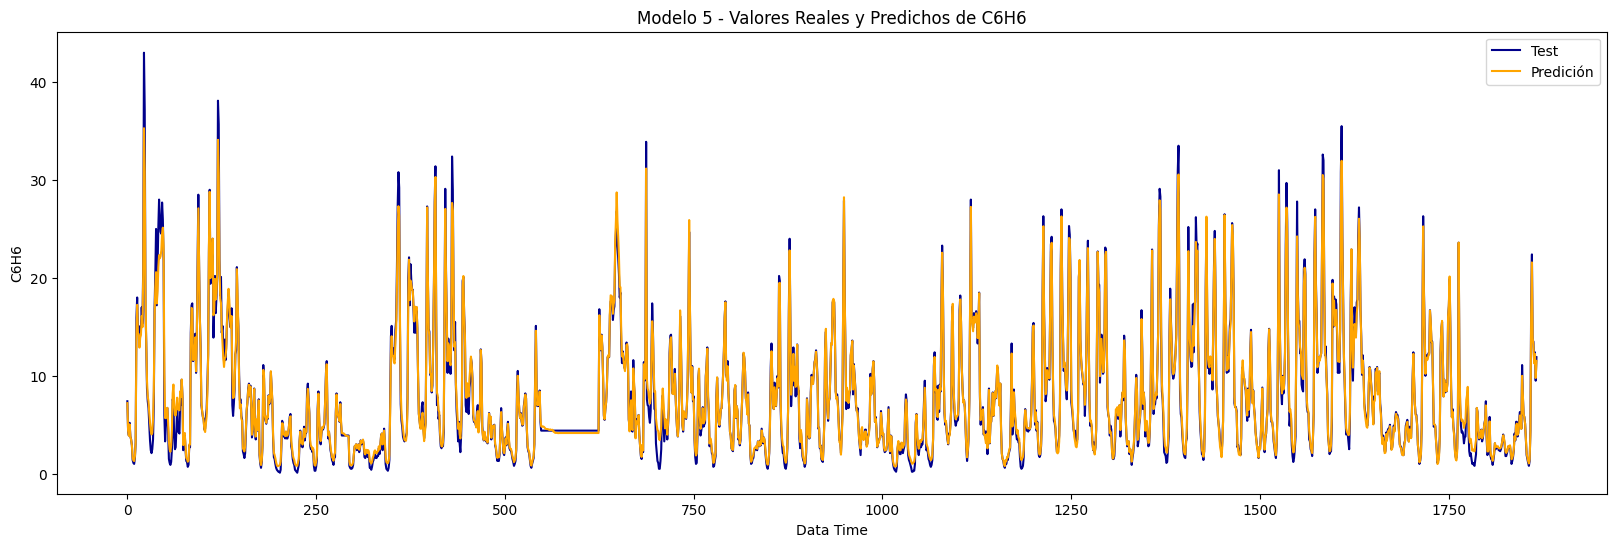

In [18]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Data Time')
plt.ylabel('C6H6')
plt.title('Modelo 5 - Valores Reales y Predichos de C6H6')
plt.legend()
plt.show()


**Grafico de la prediccion completa, train y test**

In [21]:
# Predicción para las próximas 24 horas
future_predictions = []
current_points = df.iloc[-(lags + 1):]  # Usar los últimos 'lags + 1' puntos conocidos

for _ in range(24):
    # Crear características lagged y estacionales para los últimos puntos conocidos
    lagged_features = create_lagged_features(current_points, lags, seasonal_period)

    # Eliminar la columna 'target' para obtener solo las características (X)
    X_future = lagged_features.drop(columns=['target']).values

    # Si X_future está vacío, lanzar una advertencia
    if X_future.shape[0] == 0:
        print("Las características futuras están vacías.")
        break

    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    next_pred = model5.predict(X_future_scaled)[0]

    # Añadir la predicción actual a la lista de predicciones futuras
    future_predictions.append(next_pred)

    # Añadir la predicción actual a los puntos actuales para la siguiente iteración
    next_point = current_points.iloc[-1:].copy()
    next_point['target'] = next_pred
    current_points = pd.concat([current_points, next_point]).tail(lags + 1)

# Muestra las predicciones
print('Predicciones para las próximas 4 horas:', future_predictions)

Predicciones para las próximas 4 horas: [11.516637641281813, 11.845548109952537, 11.88369221239988, 12.194430975027004, 12.047278116227645, 11.958075067078722, 11.757947276217745, 11.498647088562667, 11.519338098944965, 11.66174886099638, 11.69337856448427, 11.595334272043738, 11.551575220576998, 11.606048038734777, 11.763516676209157, 11.959924697552582, 11.784900675082788, 11.339484123833579, 11.458303716025958, 11.879147897165623, 11.959539916236265, 12.053512282443185, 12.068098613199444, 12.096104785881263]


In [22]:
# Predicción para la próxima hora
current_point = df.iloc[-lags:]  # Usar los últimos 'lags' puntos conocidos

# Crear características lagged y estacionales para el último punto conocido
lagged_features = create_lagged_features(current_point, lags, seasonal_period)

# Eliminar la columna 'target' para obtener solo las características (X)
X_future = lagged_features.drop(columns=['target']).values

# Si X_future está vacío, lanzar una advertencia
if X_future.shape[0] == 0:
    print("Las características futuras están vacías.")
else:
    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    next_pred = model5.predict(X_future_scaled)[0]

    print('Predicción para la próxima hora:', next_pred)

Las características futuras están vacías.


In [23]:
# Predicción en los datos de entrenamiento
y_pred_train = model5.predict(X_train_scaled)

In [24]:
y_pred_completo = np.concatenate((y_pred, y_pred_train))
y_completo = np.concatenate((y_train, y_test))

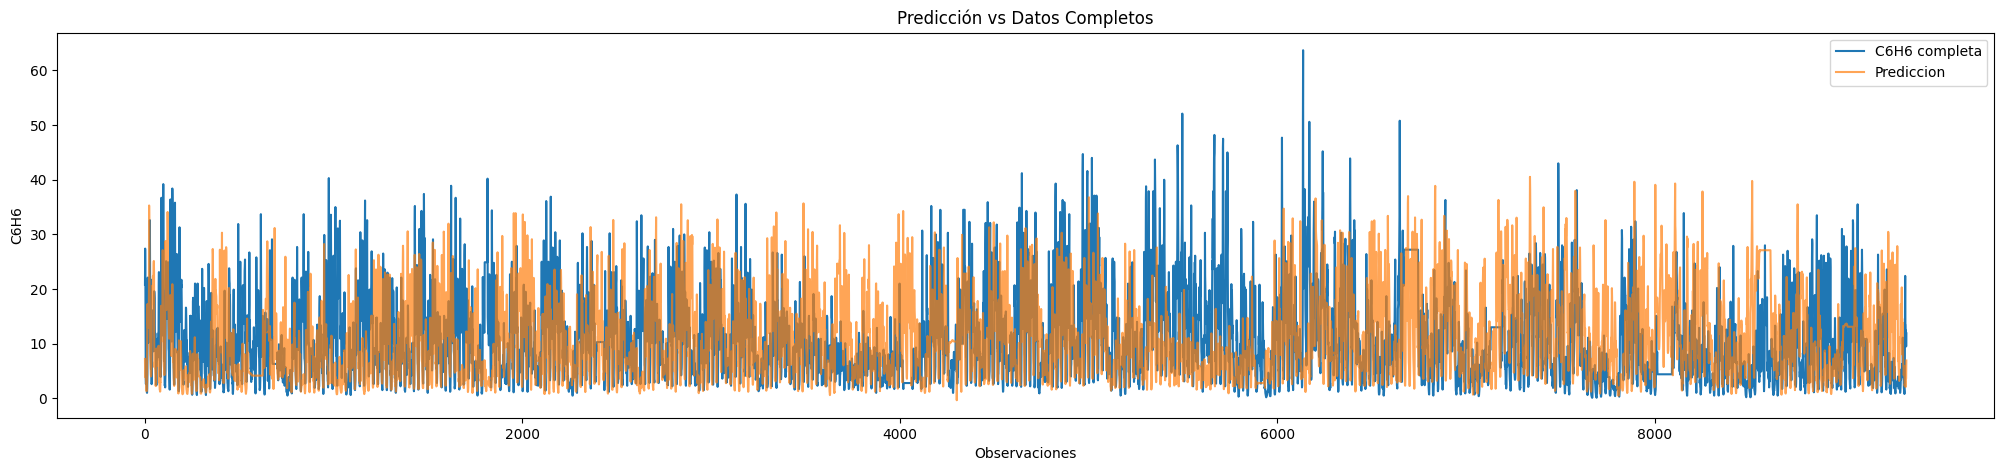

In [27]:
fig, ax = plt.subplots(figsize=(25,5))

ax.plot(y_completo.flatten(),label="C6H6 completa")
ax.plot(y_pred_completo,label="Prediccion", alpha=0.7)
ax.set_title("Predicción vs Datos Completos")
ax.set_xlabel("Observaciones")
ax.set_ylabel("C6H6")
plt.legend()
plt.show()


In [ ]:
#rmse sobre todo los valores predecidos
diferencia=np.square(y_completo-y_pred_completo)
proms=np.mean(diferencia)
rmse=np.sqrt(proms)
print(rmse)

10.426609691574814


**Prediccion para 24 horas**

In [ ]:
# Predicción para la próxima hora se usan los lags+1 puntos conocidos para asegurar suficientes datos para características
current_points = df.iloc[-(lags + 1):]

# Crear características lagged y estacionales para el último punto conocido
lagged_features = create_lagged_features(current_points, lags, seasonal_period)

# Eliminar la columna 'target' para obtener solo las características (X)
X_future = lagged_features.drop(columns=['target']).values

# Si X_future está vacío, lanzar una advertencia
if X_future.shape[0] == 0:
    print("Las características futuras están vacías.")
else:
    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    pred_1hora = model5.predict(X_future_scaled)[0]

    print('Predicción para la próxima hora:', pred_1hora)

Predicción para la próxima hora: 11.51663764128177


In [ ]:
# Predicción para las próximas 24 horas
future_predictions = []
current_points = df.iloc[-(lags + 1):]

for _ in range(24):

    lagged_features = create_lagged_features(current_points, lags, seasonal_period)

    # Eliminar la columna 'target' para obtener solo las características (X)
    X_future = lagged_features.drop(columns=['target']).values

    # Si X_future está vacío, lanzar una advertencia
    if X_future.shape[0] == 0:
        print("Las características futuras están vacías.")
        break

    X_future_scaled = scaler.transform(X_future)
    next_pred = model5.predict(X_future_scaled)[0]
    future_predictions.append(next_pred)

    # Añadir la predicción actual a los puntos actuales para la siguiente iteración
    next_point = current_points.iloc[-1:].copy()
    next_point['target'] = next_pred
    current_points = pd.concat([current_points, next_point]).tail(lags + 1)

print('Predicciones para las próximas 24 horas:', future_predictions)

Predicciones para las próximas 24 horas: [11.51663764128177, 11.84554810995258, 11.883692212399895, 12.194430975027, 12.047278116227668, 11.958075067078731, 11.757947276217754, 11.498647088562652, 11.519338098944974, 11.661748860996413, 11.69337856448431, 11.595334272043747, 11.55157522057696, 11.606048038734777, 11.763516676209154, 11.959924697552577, 11.784900675082785, 11.339484123833593, 11.458303716025974, 11.87914789716558, 11.959539916236265, 12.053512282443185, 12.068098613199409, 12.096104785881291]


In [ ]:
# Crear un índice para las predicciones futuras
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
furute_index = future_index.strftime('%Y-%m-%d %H:%M:%S')
print(furute_index)

Index(['2005-04-04 15:00:00', '2005-04-04 16:00:00', '2005-04-04 17:00:00',
       '2005-04-04 18:00:00', '2005-04-04 19:00:00', '2005-04-04 20:00:00',
       '2005-04-04 21:00:00', '2005-04-04 22:00:00', '2005-04-04 23:00:00',
       '2005-04-05 00:00:00', '2005-04-05 01:00:00', '2005-04-05 02:00:00',
       '2005-04-05 03:00:00', '2005-04-05 04:00:00', '2005-04-05 05:00:00',
       '2005-04-05 06:00:00', '2005-04-05 07:00:00', '2005-04-05 08:00:00',
       '2005-04-05 09:00:00', '2005-04-05 10:00:00', '2005-04-05 11:00:00',
       '2005-04-05 12:00:00', '2005-04-05 13:00:00', '2005-04-05 14:00:00'],
      dtype='object')


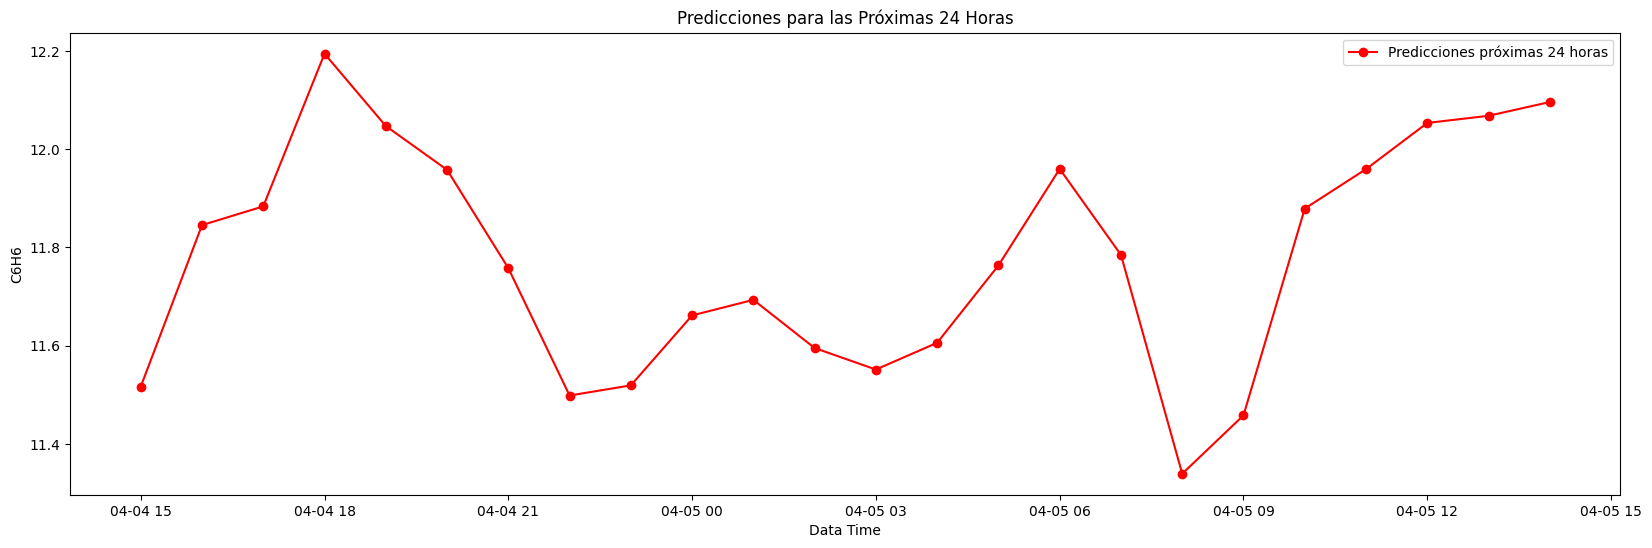

In [ ]:
# Grafica las predicciones futuras junto con los datos actuales
plt.figure(figsize=(20, 6))

# Predicciones futuras
plt.plot(future_index, future_predictions, label='Predicciones próximas 24 horas', color='red', marker='o')

plt.xlabel('Data Time')
plt.ylabel('C6H6')
plt.title('Predicciones para las Próximas 24 Horas')
plt.legend()
plt.show()

In [ ]:
# Filtrar las últimas 100 observaciones de la columna 'C6H6' con los indices
ultimos_100_datos = df['C6H6'].tail(100)
print(ultimos_100_datos)

Datetime
2005-03-31 11:00:00     4.2
2005-03-31 12:00:00     4.3
2005-03-31 13:00:00     4.0
2005-03-31 14:00:00     3.1
2005-03-31 15:00:00     3.7
                       ... 
2005-04-04 10:00:00    13.5
2005-04-04 11:00:00    11.4
2005-04-04 12:00:00    12.4
2005-04-04 13:00:00     9.5
2005-04-04 14:00:00    11.9
Name: C6H6, Length: 100, dtype: float64


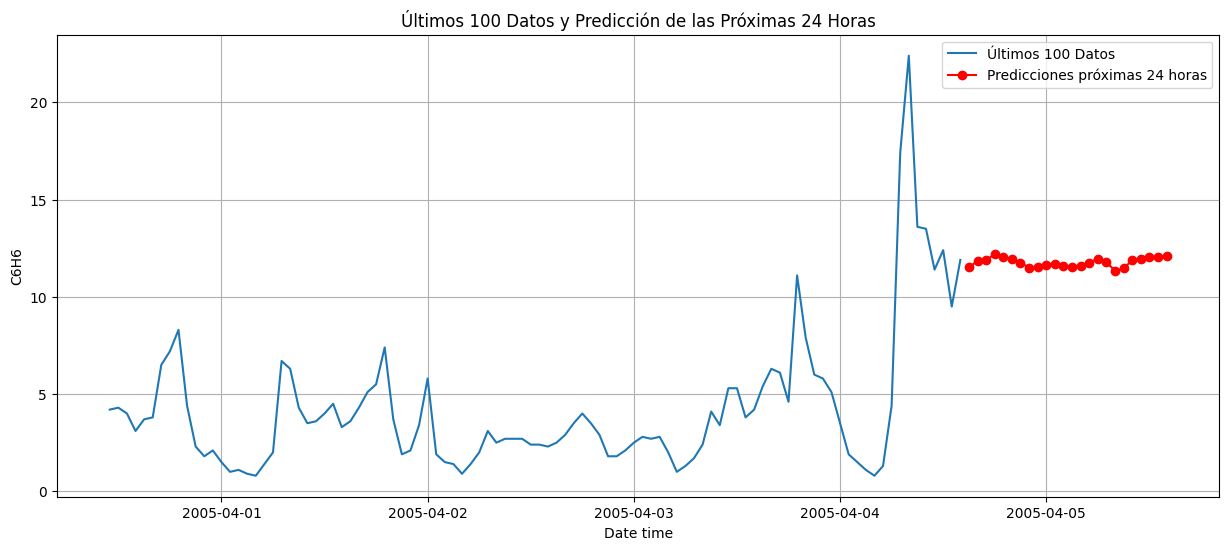

In [ ]:
# Graficar los últimos 100 datos y las predicciones futuras
plt.figure(figsize=(15, 6))

# Graficar los últimos 100 datos
plt.plot(ultimos_100_datos.index, ultimos_100_datos, label='Últimos 100 Datos')

# Graficar las predicciones futuras
plt.plot(future_index, future_predictions, label='Predicciones próximas 24 horas', color='red', marker='o')

# Configurar el gráfico
plt.xlabel('Date time')
plt.ylabel('C6H6')
plt.title('Últimos 100 Datos y Predicción de las Próximas 24 Horas')
plt.legend()
plt.grid(True)
plt.show()